In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [3]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/newmethod.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/training/newmethod.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold1.pkl
Strategy: memory

📊 Data Splits:
  Train: 1 samples
  Val: 1 samples
  Test: 1 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 16
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.5

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 16
Train split: 0 CRC + 0 Xenium + 0 TissueNet + 1 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg + 0 BC + 0 CoNSeP + 0 Kumar + 0 CPM17
Val   split: 0 CRC + 0 Xenium + 0 TissueNet + 1 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg

DATASET INVESTIGATION

📊 Dataset Sizes:
   Training batches: 166
   Validation batches: 158
   Test batches: 171

📦 Multi-Modal Setup:
   H&E image: torch.Size([4, 3, 512, 512])
   MIF image: torch.Size([4, 2, 512, 512])
   Combined: torch.Size([4, 5, 512, 512])

🎯 Annotations Available:
   H&E nuclei instances: 3096 max instances
   H&E cell instances: 0 max instances
   MIF nuclei instances: 0 max instances
   MIF cell instances: 0 max instances

🔬 H&E Nuclei Details:
   Sample 1: 3096 nuclei | 47048 foreground pixels
   Sample 2: 850 nuclei | 35884 foreground pixels
   Sample 3: 899 nuclei | 47505 foreground pixels
   Sample 4: 409 nuclei | 58910 foreground pixels


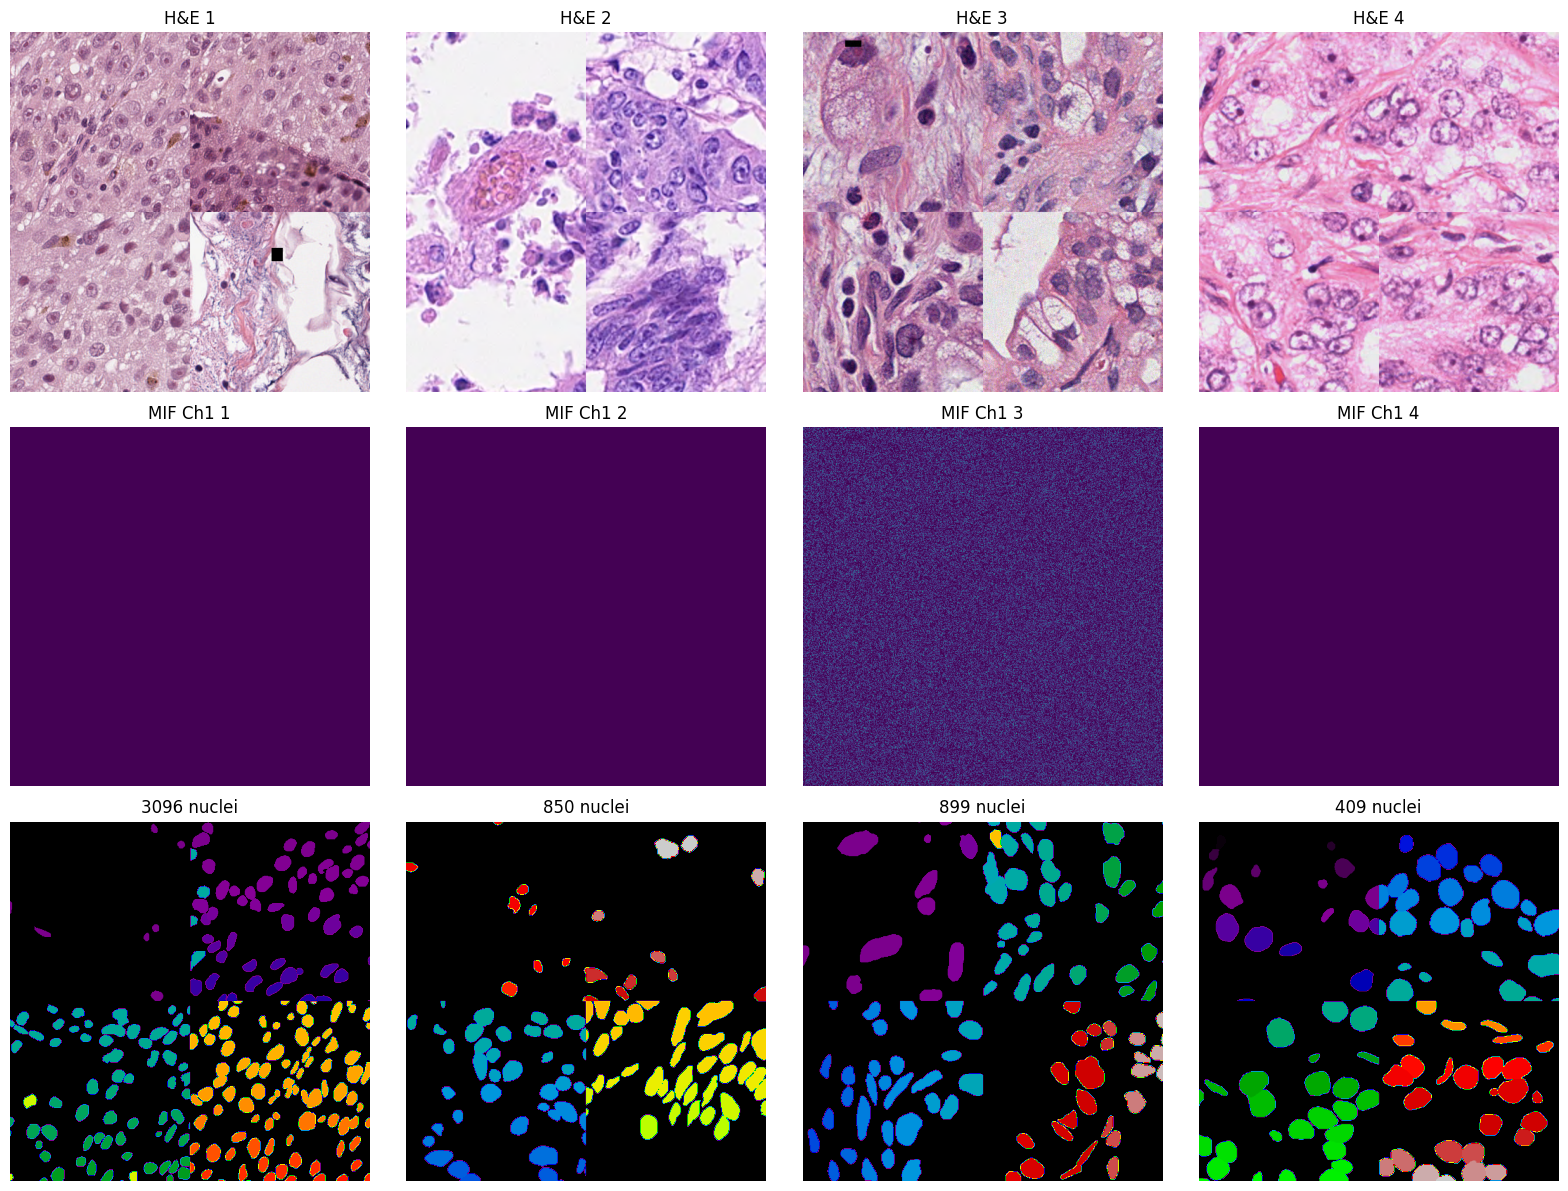


✅ Visualization saved!

📊 Key Insight:
   - This batch has H&E annotations (rich!)
   - MIF annotations are empty (expected)
   - Cell masks are empty (nucleus-focused)
   - HV maps pre-computed: torch.Size([4, 2, 512, 512])


In [4]:
# Cell 4: Dataset Investigation (Fixed for multi-modal data)
import torch
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("DATASET INVESTIGATION")
print("=" * 60)

# Basic stats
print(f"\n📊 Dataset Sizes:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Get batch
batch = next(iter(train_loader))

print(f"\n📦 Multi-Modal Setup:")
print(f"   H&E image: {batch['he_image'].shape}")
print(f"   MIF image: {batch['mif_image'].shape}")
print(f"   Combined: {batch['image'].shape}")

print(f"\n🎯 Annotations Available:")
print(f"   H&E nuclei instances: {batch['he_nuclei_instance'].max().item():.0f} max instances")
print(f"   H&E cell instances: {batch['he_cell_instance'].max().item():.0f} max instances")
print(f"   MIF nuclei instances: {batch['mif_nuclei_instance'].max().item():.0f} max instances")
print(f"   MIF cell instances: {batch['mif_cell_instance'].max().item():.0f} max instances")

# Analyze HE nuclei (main target)
he_nuclei_inst = batch['he_nuclei_instance']
print(f"\n🔬 H&E Nuclei Details:")
for i in range(min(4, len(he_nuclei_inst))):
    n_nuclei = he_nuclei_inst[i].max().item()
    has_mask = (batch['he_nuclei_mask'][i] > 0).sum().item()
    print(f"   Sample {i+1}: {n_nuclei:.0f} nuclei | {has_mask} foreground pixels")

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(min(4, len(batch['he_image']))):
    # H&E image
    he_img = batch['he_image'][i].permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(he_img)
    axes[0, i].set_title(f"H&E {i+1}")
    axes[0, i].axis('off')
    
    # MIF image (show first channel)
    mif_img = batch['mif_image'][i, 0].cpu().numpy()
    axes[1, i].imshow(mif_img, cmap='viridis')
    axes[1, i].set_title(f"MIF Ch1 {i+1}")
    axes[1, i].axis('off')
    
    # Instance mask
    inst = batch['he_nuclei_instance'][i].cpu().numpy()
    axes[2, i].imshow(inst, cmap='nipy_spectral')
    axes[2, i].set_title(f"{inst.max():.0f} nuclei")
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved!")
print(f"\n📊 Key Insight:")
print(f"   - This batch has H&E annotations (rich!)")
print(f"   - MIF annotations are empty (expected)")
print(f"   - Cell masks are empty (nucleus-focused)")
print(f"   - HV maps pre-computed: {batch['he_nuclei_hv'].shape}")

In [ ]:
# Cell 5: ACTUAL INR-based Nuclei Segmentation with Instance Separation - Complete PoC
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from scipy.ndimage import label as connected_components
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Feature Encoder (simple UNet-style)
class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU()
        )
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        return e3

# INR Decoder
class INRDecoder(nn.Module):
    def __init__(self, feature_dim=256, hidden_dim=256):
        super().__init__()
        self.coord_dim = 32
        
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim + self.coord_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1 + 16)
        )
        
    def positional_encoding(self, coords, L=8):
        freq = 2.0 ** torch.linspace(0, L-1, L, device=coords.device)
        coords_encoded = []
        for i in range(2):
            for f in freq:
                coords_encoded.append(torch.sin(2 * np.pi * f * coords[:, i]))
                coords_encoded.append(torch.cos(2 * np.pi * f * coords[:, i]))
        return torch.stack(coords_encoded, dim=-1)
    
    def forward(self, features, coords):
        B, C, H, W = features.shape
        N = coords.shape[1]
        
        coords_grid = coords * 2 - 1
        coords_grid = coords_grid.unsqueeze(1)
        
        sampled_features = F.grid_sample(
            features, coords_grid, 
            mode='bilinear', align_corners=False
        )
        sampled_features = sampled_features.squeeze(2).permute(0, 2, 1)
        
        coords_flat = coords.reshape(B * N, 2)
        coords_encoded = self.positional_encoding(coords_flat)
        coords_encoded = coords_encoded.reshape(B, N, -1)
        
        mlp_input = torch.cat([sampled_features, coords_encoded], dim=-1)
        output = self.mlp(mlp_input)
        
        binary = torch.sigmoid(output[..., 0])
        embeddings = F.normalize(output[..., 1:], dim=-1)
        
        return binary, embeddings

# Full Model
class INRNucleiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = FeatureEncoder()
        self.inr_decoder = INRDecoder(feature_dim=256, hidden_dim=256)
        
    def forward(self, images, coords):
        features = self.encoder(images)
        binary, embeddings = self.inr_decoder(features, coords)
        return binary, embeddings

def sample_coordinates(inst_masks, n_samples=2048):
    B, H, W = inst_masks.shape
    coords_list = []
    
    for b in range(B):
        inst = inst_masks[b]
        
        boundaries_v = (inst[1:, :] != inst[:-1, :])
        boundaries_h = (inst[:, 1:] != inst[:, :-1])
        
        boundaries_v = F.pad(boundaries_v.float(), (0, 0, 0, 1))
        boundaries_h = F.pad(boundaries_h.float(), (0, 1, 0, 0))
        boundaries = (boundaries_v + boundaries_h) > 0
        
        n_boundary = int(n_samples * 0.7)
        n_random = n_samples - n_boundary
        
        boundary_coords = boundaries.nonzero()
        if len(boundary_coords) > n_boundary:
            idx = torch.randperm(len(boundary_coords), device=inst.device)[:n_boundary]
            boundary_coords = boundary_coords[idx]
        else:
            n_random += n_boundary - len(boundary_coords)
        
        random_y = torch.randint(0, H, (n_random,), device=inst.device)
        random_x = torch.randint(0, W, (n_random,), device=inst.device)
        random_coords = torch.stack([random_y, random_x], dim=1)
        
        if len(boundary_coords) > 0:
            all_coords = torch.cat([boundary_coords, random_coords], dim=0)[:n_samples]
        else:
            all_coords = random_coords[:n_samples]
        
        coords_norm = all_coords.float()
        coords_norm[:, 0] /= (H - 1)
        coords_norm[:, 1] /= (W - 1)
        coords_norm = coords_norm[:, [1, 0]]
        
        coords_list.append(coords_norm)
    
    return torch.stack(coords_list, dim=0)

def inr_contrastive_loss(embeddings, coords, inst_masks):
    B, N, _ = embeddings.shape
    H, W = inst_masks.shape[1:]
    
    total_loss = 0
    n_valid = 0
    
    for b in range(B):
        emb = embeddings[b]
        coord = coords[b]
        inst = inst_masks[b]
        
        coord_pixel = (coord * torch.tensor([W-1, H-1], device=coord.device)).long()
        coord_pixel[:, 0] = coord_pixel[:, 0].clamp(0, W-1)
        coord_pixel[:, 1] = coord_pixel[:, 1].clamp(0, H-1)
        inst_ids = inst[coord_pixel[:, 1], coord_pixel[:, 0]]
        
        for _ in range(20):
            unique_ids = inst_ids.unique()
            valid_ids = unique_ids[unique_ids > 0]
            if len(valid_ids) == 0:
                continue
                
            inst_id = valid_ids[torch.randint(0, len(valid_ids), (1,), device=valid_ids.device)]
            mask = (inst_ids == inst_id)
            if mask.sum() < 2:
                continue
            
            pos_idx = mask.nonzero().squeeze(-1)
            if len(pos_idx) < 2:
                continue
            idx = torch.randperm(len(pos_idx), device=pos_idx.device)[:2]
            emb1 = emb[pos_idx[idx[0]]]
            emb2 = emb[pos_idx[idx[1]]]
            pos_dist = (emb1 - emb2).pow(2).sum()
            
            other_mask = (inst_ids > 0) & (inst_ids != inst_id)
            if other_mask.sum() > 0:
                neg_idx = other_mask.nonzero().squeeze(-1)
                if len(neg_idx.shape) == 0:
                    neg_idx = neg_idx.unsqueeze(0)
                neg_idx = neg_idx[torch.randint(0, len(neg_idx), (1,), device=neg_idx.device)]
                emb3 = emb[neg_idx]
                neg_dist = (emb1 - emb3).pow(2).sum()
                
                total_loss += pos_dist + F.relu(1.0 - neg_dist)
                n_valid += 1
    
    return total_loss / (n_valid + 1e-8)

# Instance separation from embeddings
def embeddings_to_instances(binary_mask, embeddings, bandwidth=0.3, min_size=10):
    """
    Convert binary mask + embeddings to instance segmentation
    binary_mask: [H, W] - foreground mask
    embeddings: [H, W, D] - embedding vectors
    """
    H, W, D = embeddings.shape
    
    # Get foreground pixels
    fg_mask = binary_mask > 0.5
    if fg_mask.sum() == 0:
        return np.zeros((H, W), dtype=np.int32)
    
    # Extract embeddings for foreground pixels
    fg_coords = np.argwhere(fg_mask)  # [N, 2]
    fg_embeddings = embeddings[fg_mask]  # [N, D]
    
    # MeanShift clustering on embeddings
    try:
        clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=1)
        labels = clustering.fit_predict(fg_embeddings)
    except:
        # Fallback to connected components if clustering fails
        instance_map = np.zeros((H, W), dtype=np.int32)
        cc_labels, n_components = connected_components(fg_mask)
        instance_map[fg_mask] = cc_labels[fg_mask]
        return instance_map
    
    # Create instance map
    instance_map = np.zeros((H, W), dtype=np.int32)
    for idx, (y, x) in enumerate(fg_coords):
        instance_map[y, x] = labels[idx] + 1
    
    # Remove small instances
    for inst_id in np.unique(instance_map)[1:]:
        if (instance_map == inst_id).sum() < min_size:
            instance_map[instance_map == inst_id] = 0
    
    # Renumber instances
    unique_ids = np.unique(instance_map)[1:]
    for new_id, old_id in enumerate(unique_ids, start=1):
        instance_map[instance_map == old_id] = new_id + 10000
    instance_map[instance_map > 10000] -= 10000
    
    return instance_map

# Panoptic Quality metric
def calculate_pq(pred_inst, gt_inst):
    """Calculate Panoptic Quality"""
    pred_ids = np.unique(pred_inst)[1:]
    gt_ids = np.unique(gt_inst)[1:]
    
    if len(pred_ids) == 0 or len(gt_ids) == 0:
        return 0.0, 0.0, 0.0
    
    iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
    
    for i, gt_id in enumerate(gt_ids):
        gt_mask = (gt_inst == gt_id)
        for j, pred_id in enumerate(pred_ids):
            pred_mask = (pred_inst == pred_id)
            intersection = (gt_mask & pred_mask).sum()
            union = (gt_mask | pred_mask).sum()
            iou_matrix[i, j] = intersection / (union + 1e-8)
    
    # Match instances (IoU > 0.5)
    matched_gt = set()
    matched_pred = set()
    iou_sum = 0
    
    while True:
        max_iou = iou_matrix.max()
        if max_iou < 0.5:
            break
        max_pos = np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)
        matched_gt.add(max_pos[0])
        matched_pred.add(max_pos[1])
        iou_sum += max_iou
        iou_matrix[max_pos[0], :] = 0
        iou_matrix[:, max_pos[1]] = 0
    
    tp = len(matched_gt)
    fp = len(pred_ids) - len(matched_pred)
    fn = len(gt_ids) - len(matched_gt)
    
    pq = iou_sum / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    sq = iou_sum / (tp + 1e-8)  # Segmentation Quality
    rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)  # Recognition Quality
    
    return pq, sq, rq

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = INRNucleiModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
bce_loss = nn.BCELoss()

print("🚀 Training INR-based Nuclei Segmentation with Instance Separation")
print(f"Device: {device}")
print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M\n")

# Training loop
for epoch in range(15):
    model.train()
    epoch_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/5")
    for batch in pbar:
        he_images = batch['he_image'].to(device)
        inst_masks = batch['he_nuclei_instance'].to(device)
        binary_masks = batch['he_nuclei_mask'].to(device)
        
        coords = sample_coordinates(inst_masks, n_samples=2048)
        
        B, N = coords.shape[:2]
        H, W = binary_masks.shape[1:]
        coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
        coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
        coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
        
        binary_gt = binary_masks[
            torch.arange(B, device=device).unsqueeze(1),
            coord_pixel[:, :, 1],
            coord_pixel[:, :, 0]
        ].float()
        
        binary_pred, embeddings = model(he_images, coords)
        
        loss_binary = bce_loss(binary_pred, binary_gt)
        loss_contrast = inr_contrastive_loss(embeddings, coords, inst_masks)
        loss = loss_binary + 0.3 * loss_contrast
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    print(f"Epoch {epoch+1}: Loss={epoch_loss/len(train_loader):.4f}")

print("\n✅ INR Training complete!\n")

# Evaluation with instance segmentation
print("🔍 Evaluating instance segmentation on test set...\n")
model.eval()

test_batch = next(iter(test_loader))
he_images = test_batch['he_image'].to(device)[:4]
inst_gt = test_batch['he_nuclei_instance'].cpu().numpy()[:4]

# Create dense grid
H, W = 512, 512
y_coords = torch.linspace(0, 1, H, device=device)
x_coords = torch.linspace(0, 1, W, device=device)
grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
coords_dense = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

predictions = []
instance_predictions = []
pq_scores = []

with torch.no_grad():
    for i in range(len(he_images)):
        img = he_images[i:i+1]
        coords_batch = coords_dense.unsqueeze(0)
        
        binary_pred, embeddings = model(img, coords_batch)
        binary_pred = binary_pred.reshape(H, W).cpu().numpy()
        embeddings = embeddings.reshape(H, W, 16).cpu().numpy()
        
        # Convert to instances
        inst_pred = embeddings_to_instances(binary_pred, embeddings, bandwidth=0.3, min_size=10)
        
        predictions.append(binary_pred)
        instance_predictions.append(inst_pred)
        
        # Calculate metrics
        pq, sq, rq = calculate_pq(inst_pred, inst_gt[i])
        pq_scores.append((pq, sq, rq))
        
        print(f"Image {i+1}: {inst_pred.max():.0f} nuclei predicted | PQ={pq:.3f}, SQ={sq:.3f}, RQ={rq:.3f}")

avg_pq = np.mean([s[0] for s in pq_scores])
avg_sq = np.mean([s[1] for s in pq_scores])
avg_rq = np.mean([s[2] for s in pq_scores])
print(f"\n📊 Average Metrics: PQ={avg_pq:.3f}, SQ={avg_sq:.3f}, RQ={avg_rq:.3f}")

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    # H&E image
    axes[i, 0].imshow(he_images[i].permute(1, 2, 0).cpu().numpy())
    axes[i, 0].set_title(f"H&E {i+1}")
    axes[i, 0].axis('off')
    
    # GT instances
    axes[i, 1].imshow(inst_gt[i], cmap='nipy_spectral')
    axes[i, 1].set_title(f"GT: {inst_gt[i].max():.0f} nuclei")
    axes[i, 1].axis('off')
    
    # Predicted instances
    axes[i, 2].imshow(instance_predictions[i], cmap='nipy_spectral')
    axes[i, 2].set_title(f"Pred: {instance_predictions[i].max():.0f} nuclei\nPQ={pq_scores[i][0]:.3f}")
    axes[i, 2].axis('off')
    
    # Binary prediction
    axes[i, 3].imshow(predictions[i], cmap='gray')
    axes[i, 3].set_title("Binary Mask")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

print("\n🎯 INR with Instance Segmentation Complete!")
print(f"💡 Compare PQ={avg_pq:.3f} with HoVer-Net's ~0.50-0.52 on PanNuke")

🚀 Training INR-based Nuclei Segmentation with Instance Separation
Device: cuda
Model params: 0.58M



Epoch 1/5: 100%|██████████| 166/166 [00:12<00:00, 12.89it/s, loss=0.506]


Epoch 1: Loss=0.6294


Epoch 2/5: 100%|██████████| 166/166 [00:13<00:00, 12.09it/s, loss=0.385]


Epoch 2: Loss=0.4930


Epoch 3/5: 100%|██████████| 166/166 [00:12<00:00, 12.83it/s, loss=0.440]


Epoch 3: Loss=0.4491


Epoch 4/5:   8%|▊         | 14/166 [00:02<00:14, 10.57it/s, loss=0.539]